In [676]:
import sys
# setting path
sys.path.append('..')

In [677]:
import numpy as np
import matplotlib.pyplot as plt

from src import io, var, utils, fourier, lin_reg, reconstruction, physics
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

Setup objects and read data. Specify the extent of the lat-lon grid to be read in.

In [532]:
# initialise data objects
grid = var.grid()
topo = var.topo_cell()

# read grid
reader = io.ncdata()
fn = '../data/icon_compact.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

# read topography
fn = '../data/topo_compact.nc'
reader.read_dat(fn, topo)

# we only keep the topography that is inside this lat-lon extent.
lat_verts = np.array([52.,64.,64.])
lon_verts = np.array([-141.,-158.,-127.])

reader.read_topo(topo, topo, lon_verts, lat_verts)

Data fetched...


Plot the loaded topography...

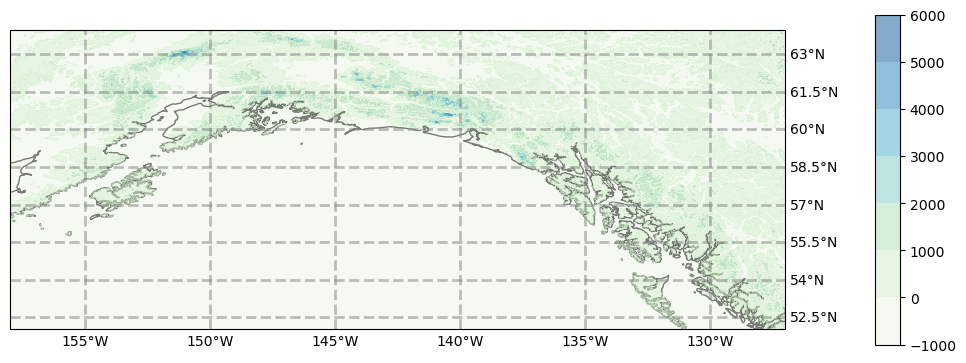

In [533]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

topo.gen_mgrids()

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
im = ax.contourf(topo.lon_grid, topo.lat_grid, topo.topo,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
            cmap='GnBu',
            # vmin=0.0,
            # vmax=3000.0
            )

cax = fig.add_axes([0.99, 0.22, 0.025, 0.55])
fig.colorbar(im, cax=cax)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False

gl.xlocator = LongitudeLocator()
gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter(auto_hide=False)
gl.yformatter = LatitudeFormatter()

ax.tick_params(axis="both",
               tickdir='out',
               length=15,
               grid_transform=ccrs.PlateCarree())

plt.show()

Setup Delaunay triangulation domain.

In [534]:
from scipy.spatial import Delaunay
import matplotlib.tri as tri

# Partition lat-lon domain into a number of coarser but regularly spaces points that will form the vertices of the Delaunay triangles.
xlen = len(topo.lon)
ylen = len(topo.lat)
xPoints = np.linspace(0,xlen-1,11)
yPoints = np.linspace(0,ylen-1,6)

YY,XX = np.meshgrid(yPoints,xPoints)

# Now we get the points by index.
points = np.array([list(item) for item in zip(XX.ravel(), YY.ravel())]).astype('int')

lat_verts = topo.lat_grid[points[:,1], points[:,0]]
lon_verts = topo.lon_grid[points[:,1], points[:,0]]

# Using these indices, we get the list of points in (lon,lat).
points = np.array([list(item) for item in zip(lon_verts, lat_verts)])

lats = points[:,1]
lons = points[:,0]

# Using scipy spatial, we setup the Delaunay decomposition
tri = Delaunay(points)

# Convert the vertices of the simplices to lat-lon values.
tri_lat_verts = lats[tri.simplices]
tri_lon_verts = lons[tri.simplices]

print("number of triangles =", len(tri_lat_verts))

# Compute the centroid for each vertex.
tri_clats = tri_lat_verts.sum(axis=1) / 3.0
tri_clons = tri_lon_verts.sum(axis=1) / 3.0

number of triangles = 100


Plot the Delaunay triangular, its vertices, and the computed centroids against the background of the topography.

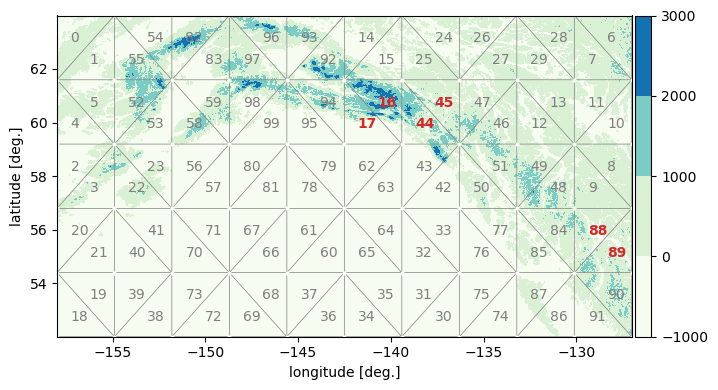

In [821]:
import matplotlib.colors as colors

plt.figure(figsize=(8,4))

levels = np.linspace(-1000.0, 3000.0, 5)

topo_fudge = np.copy(topo.topo)
# topo_fudge[np.where(topo_fudge < 5.0)] = np.nan
im = plt.contourf(topo.lon_grid, topo.lat_grid, topo_fudge, levels=levels, cmap='GnBu')
im.set_clim(0.0, 3000.0)

cbar = plt.colorbar(im,fraction=0.2,pad=0.005, shrink=1.0)
plt.triplot(points[:,0], points[:,1], tri.simplices, c='C7', lw=0.5)
plt.plot(points[:,0], points[:,1], 'wo', ms=2.0)
# plt.plot(tri_clons, tri_clats, 'rx', ms=4.0)

tri_indices = np.arange(len(tri_lat_verts))

highlight_indices = [44,45, 88,89, 16,17]
for idx in tri_indices:
    colour = 'C7'
    fw = None
    
    if idx in highlight_indices:
        colour='C3'
        fw = 'bold'
        
    plt.annotate(tri_indices[idx], (tri_clons[idx],tri_clats[idx]), (tri_clons[idx]-0.3,tri_clats[idx]-0.2), c=colour, fontweight=fw)

plt.xlabel("longitude [deg.]")
plt.ylabel("latitude [deg.]")
plt.tight_layout()
plt.savefig('output/delaunay.pdf')
plt.show()

Define function that computes whether a point is in a polygon, and rescales the lat-lon grid to a local coordinate between [0,1].

Taken from: https://github.com/sasamil/PointInPolygon_Py/blob/master/pointInside.py

In [8]:
import numba as nb

def mask_wrapper(polygon):
    return lambda p : is_inside_sm(p, polygon)

@nb.njit
def is_inside_sm(point, polygon):
    length = len(polygon)-1
    dy2 = point[1] - polygon[0][1]
    intersections = 0
    ii = 0
    jj = 1

    while ii<length:
        dy  = dy2
        dy2 = point[1] - polygon[jj][1]

        # consider only lines which are not completely above/bellow/right from the point
        if dy*dy2 <= 0.0 and (point[0] >= polygon[ii][0] or point[0] >= polygon[jj][0]):

            # non-horizontal line
            if dy<0 or dy2<0:
                F = dy*(polygon[jj][0] - polygon[ii][0])/(dy-dy2) + polygon[ii][0]

                if point[0] > F: # if line is left from the point - the ray moving towards left, will intersect it
                    intersections += 1
                elif point[0] == F: # point on line
                    return 1

            # point on upper peak (dy2=dx2=0) or horizontal line (dy=dy2=0 and dx*dx2<=0)
            elif dy2==0 and (point[0]==polygon[jj][0] or (dy==0 and (point[0]-polygon[ii][0])*(point[0]-polygon[jj][0])<=0)):
                return 1

        ii = jj
        jj += 1

    #print 'intersections =', intersections
    return intersections & 1  

def rescale(arr):
    arr -= arr.min()
    arr /= arr.max()
    
    return arr

Prepare Delaunay simplices for the looping...

In [9]:
# Make circular vertex points, e.g. the last point is also the first point:
circ_tri_lat_verts = np.hstack((tri_lat_verts,tri_lat_verts[:,0].reshape(-1,1)))
circ_tri_lon_verts = np.hstack((tri_lon_verts,tri_lon_verts[:,0].reshape(-1,1)))

# Rescale everything to be between 0 and 1 (otherwise the function I copied off github above wouldn't work, lol).
circ_tri_lon_verts = rescale(circ_tri_lon_verts)
circ_tri_lat_verts = rescale(circ_tri_lat_verts)

# Let's just regenerate the lat-lon meshgrids to be safe... (in case we accidentally changed the values in the meantime).
topo.gen_mgrids()

# Now, we want to check for each point of the topography (given by it's lat-lon pair), whether the point is inside our triangle/polygon of interest.

# To do this, we setup a list that is of size: (no. of points x 2). 
lat_grid_tmp = np.expand_dims(np.copy(topo.lat_grid),-1)
lon_grid_tmp = np.expand_dims(np.copy(topo.lon_grid),-1)

lat_grid_tmp = rescale(lat_grid_tmp)
lon_grid_tmp = rescale(lon_grid_tmp)

lat_lon_mgrid = np.stack((lon_grid_tmp, lat_grid_tmp), axis=2).reshape(-1,2)

In [14]:
print(lat_lon_mgrid.shape)

(5356800, 2)


Now we do the main looping.

In [15]:
print(topo.lat_grid.shape)

(1440, 3720)


In [246]:
def get_lat_lon_segments(lat_verts, lon_verts, cell, topo):
    lat_max = get_closest_idx(lat_verts.max(), topo.lat)
    lat_min = get_closest_idx(lat_verts.min(), topo.lat)
    
    lon_max = get_closest_idx(lon_verts.max(), topo.lon)
    lon_min = get_closest_idx(lon_verts.min(), topo.lon)
    
    cell.lat = topo.lat[lat_min : lat_max]
    cell.lon = topo.lon[lon_min : lon_max]
    
    cell.topo = topo.topo[lat_min:lat_max, lon_min:lon_max]
    # cell.topo -= cell.topo.mean()
    cell.mask = cell.mask[lat_min:lat_max, lon_min:lon_max]
    
    cell.gen_mgrids()
    cell.get_masked()
    
    cell.topo_m -= cell.topo_m.mean()
                        
def get_closest_idx(val, arr):
    return int(np.argmin(np.abs(arr - val)))

In [247]:
# ref: https://github.com/bosswissam/pysize

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

computing idx: 44
2911.6618169041594 4377.545959472656
ref power = 23728.18243165363
total power = 4718.659051678302
reg max, reg min = 256.1821998616078 0.0
[256.1821998616078, 240.52731166282592, 220.0372516938865, 160.6416774150776, 93.00280193915214, 89.95977313050379, 89.6240076654063, 76.79082947574928, 72.20658804366826, 71.71537806927964, 68.54606514686292, 67.48396325360423, 67.08050517726453, 65.36630179838372, 64.8819099903715, 59.56306699178819, 57.9527953269755, 56.39182940574252, 55.45385154593921, 51.29429284696644, 51.0492099831114, 50.524649739373785, 50.044078912248956, 49.43278761022606, 45.94620047948977] 25 2231.699327165506

 double reg. sum:  2861.733758459786


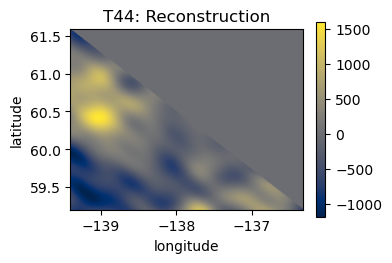

computing idx: 45
1055.6897229093577 2244.5972290039062
ref power = 23728.18243165363
total power = 1267.565152787879
reg max, reg min = 102.10972429808614 0.0
[102.10972429808614, 95.78880679252113, 89.42130894104902, 84.53530910625993, 76.69910187639398, 72.07170984447889, 68.00982757833268, 65.53767673229281, 62.23653513443882, 51.52355415074767, 43.76327551631319, 43.52632193711672, 43.02686115392003, 42.84310922739535, 38.08268248285223, 37.471238635764, 35.679180319092154, 35.363612936284, 34.84398160903151, 30.73069328315715, 28.682518521225205, 28.421087729363055, 22.673701068155605, 21.553547189287332, 12.969786724320455] 25 1267.565152787879

 double reg. sum:  1913.943769035321


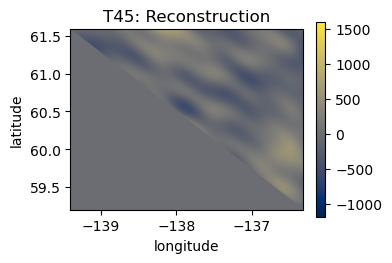

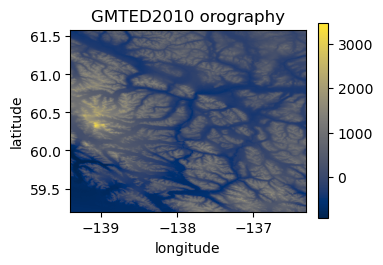

In [832]:
importlib.reload(var)
# Setup the Fourier parameters and object.
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)

# For each triangle...
# for idx in range(len(tri.simplices)):

all_cells = np.zeros(2, dtype='object')
idx_name = []
# for cnt, idx in enumerate(range(0,2)):
# for cnt, idx in enumerate(range(2,4)):
# for cnt, idx in enumerate(range(4,6)):
# for cnt, idx in enumerate(range(6,8)):
# for cnt, idx in enumerate(range(8,10)):
# for cnt, idx in enumerate(range(10,12)):
# for cnt, idx in enumerate(range(12,14)):
# for cnt, idx in enumerate(range(14,16)):
# for cnt, idx in enumerate(range(16,18)):
# for cnt, idx in enumerate(range(18,20)):
# for cnt, idx in enumerate(range(20,22)):
# for cnt, idx in enumerate(range(58,60)):         # overestimation
# for cnt, idx in enumerate(range(48,50)):
# for cnt, idx in enumerate(range(88,90)):        # underestimation
# for cnt, idx in enumerate(range(42,44)):
for cnt, idx in enumerate(range(44,46)):
# for cnt, idx in enumerate(range(54,56)):
# for cnt, idx in enumerate(range(82,84)):
# for cnt, idx in enumerate(range(90,92)):
    # initialise cell object
    cell = var.topo_cell()
    
    print("computing idx:", idx)
    simplex_lat = circ_tri_lat_verts[idx]
    simplex_lon = circ_tri_lon_verts[idx]

    polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

    init_poly = mask_wrapper(polygon)
    cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')
    
    get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo)
    
    # do fourier...
    fobj.do_full(cell)
    am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-1)
    
    dat_2D = reconstruction.recon_2D(data_recons, cell)
    
    print(dat_2D.max() - dat_2D.min(), cell.topo_m.max() - cell.topo_m.min())
    fobj.get_freq_grid(am)
    freqs = np.abs(fobj.ampls)
    
    fq_cpy = np.copy(freqs)
    total_power = fq_cpy.sum()
    
    ref_power = np.abs(np.fft.rfft2(cell.topo - cell.topo.mean())) / cell.topo.size
    ref_power = ref_power.sum()
    print("ref power =", ref_power)
    print("total power =", total_power)
    print("reg max, reg min =", fq_cpy.max(), fq_cpy.min())

    indices = []
    max_ampls = []
    for ii in range(30):
        max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
        indices.append(max_idx)
        max_ampls.append(fq_cpy[max_idx])
        max_val = fq_cpy[max_idx]
        fq_cpy[max_idx] = 0.0
        
        # if (sum(max_ampls) >= 0.1 * ref_power):
            # break
        if (sum(max_ampls) >= 1.0 * total_power):
            break
        # if sum(max_ampls) >= (total_power / 44000) * 44000:
            # break
        if max_val < 0.01 * total_power:
        # if max_ampls[-1] <= 0.1 * max_ampls[0]:
            break
        
             
    print(max_ampls, len(max_ampls), sum(max_ampls))
    k_idxs = [pair[1] for pair in indices]
    l_idxs = [pair[0] for pair in indices]
    
    fobj.set_kls(k_idxs, l_idxs)
    fobj.do_full(cell)

    am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-6)

    fobj.get_freq_grid(am)
    dat_2D = reconstruction.recon_2D(data_recons, cell)

    freqs = np.abs(fobj.ampls)
    
    print("\n double reg. sum: ",freqs.sum())
    
    analysis = var.analysis()
    analysis.get_attrs(fobj, freqs)
    analysis.recon = dat_2D
    
    cell.analysis = analysis
    
    topo_tri = cell.topo * cell.mask
    topo_tri -= topo_tri.mean()
    
    all_cells[cnt] = cell
    
    # fs = (18,5)
    # fig, axs = plt.subplots(1,3, figsize=fs)
    # fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
    # axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
    # axs[1] = fig_obj.phys_panel(axs[1], topo_tri)
    # axs[2] = fig_obj.freq_panel(axs[2], freqs)
    # plt.show()
    if cnt == 0:
        v_extent = [dat_2D.min(), dat_2D.max()]
    
    fs = (4.0,4.2)
    fig, axs = plt.subplots(1,1, figsize=fs)
    fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
    axs = fig_obj.phys_panel(axs, dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
    plt.tight_layout()
    plt.savefig('output/T%i.pdf' %idx)
    plt.show()
    
    idx_name.append(idx)
    
fs = (4.0,4.2)
fig, axs = plt.subplots(1,1, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs = fig_obj.phys_panel(axs, cell.topo, title='GMTED2010 orography', xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()])
plt.tight_layout()
plt.savefig('output/orig_topo_T%i_T%i.pdf' %(idx_name[0], idx_name[1]))
plt.show()

46590.44170926654
[[2.45166956e-14 4.46742524e+01 2.15835833e+01 ... 3.43315058e+01
  2.15835833e+01 4.46742524e+01]
 [8.65210654e+01 1.20928749e+02 9.25539043e+01 ... 5.28920444e+01
  4.98347250e+01 1.49140418e+02]
 [3.53721022e+01 2.33513349e+01 2.67256302e+01 ... 8.92577863e+00
  8.73002551e+00 1.36396359e+01]
 ...
 [1.16759724e+01 3.13067097e+01 1.21126774e+01 ... 2.48628287e+01
  2.06398560e+01 2.06752395e+01]
 [3.53721022e+01 1.36396359e+01 8.73002551e+00 ... 9.55058016e+00
  2.67256302e+01 2.33513349e+01]
 [8.65210654e+01 1.49140418e+02 4.98347250e+01 ... 5.05719265e+01
  9.25539043e+01 1.20928749e+02]]
10.0 1.0
True
0.030994088404376598
True
True
0.02550952583087994 0.004263784073500088 0.014886654952190014


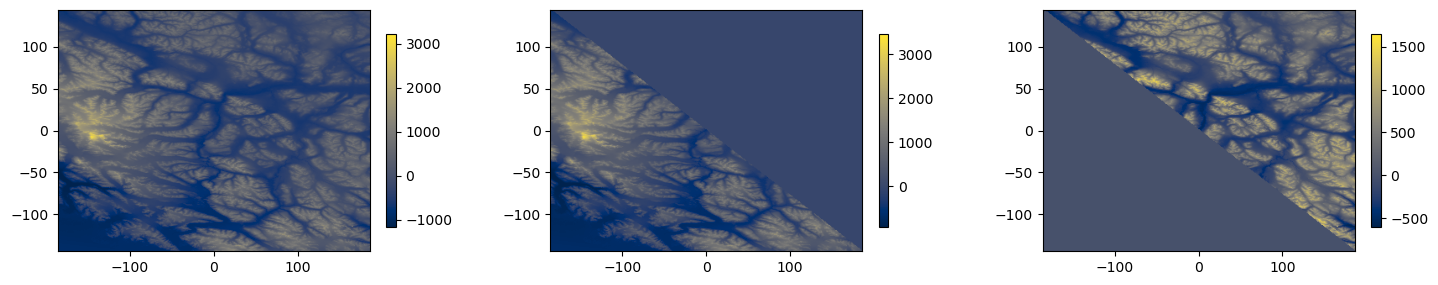

1913.943769035321


In [833]:
importlib.reload(physics)

cell0 = all_cells[0]
cell1 = all_cells[1]

from scipy.ndimage.filters import gaussian_filter
topo_blur = gaussian_filter(cell.topo - cell.topo.mean(), sigma=0)
# topo_blur = cell.topo - cell.topo.mean()

# topo_test = cell0.analysis.recon + cell1.analysis.recon
# ampls = np.fft.fft2(topo_test)

# ampls = np.fft.fft2(cell.topo - cell.topo.mean())
ampls = np.fft.fft2(topo_blur)
ampls = np.abs(ampls) / cell.topo.size

print(ampls.sum())
print(ampls)
ampls = ampls.reshape(-1,)[1:]

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = np.fft.fftfreq(cell.topo.shape[1])
lls = np.fft.fftfreq(cell.topo.shape[0])

kkg, llg = np.meshgrid(kks, lls)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = ampls
analysis.kks = kkg.reshape(-1,)[1:] #/ kkg.size
analysis.lls = llg.reshape(-1,)[1:] #/ llg.size

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis)
print(uw_ref)

uw0 = ideal.compute_uw_pmf(all_cells[0].analysis) #* all_cells[0].topo_m.size
uw1 = ideal.compute_uw_pmf(all_cells[1].analysis) #* all_cells[1].topo_m.size

uw01 = 0.5 * (uw0 + uw1) #/ all_cells[0].topo.size
print(uw0, uw1, uw01)

fs = (18,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], cell.topo * cell0.mask)
axs[2] = fig_obj.phys_panel(axs[2], cell.topo * cell1.mask)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

print(freqs.sum())

[15343002.06327461 15343002.06327461 12440692.32531508 12440692.32531508
  9441861.94341166  9441861.94341166  8941054.16611481  8941054.16611481
  5350689.60340243  5350689.60340243]


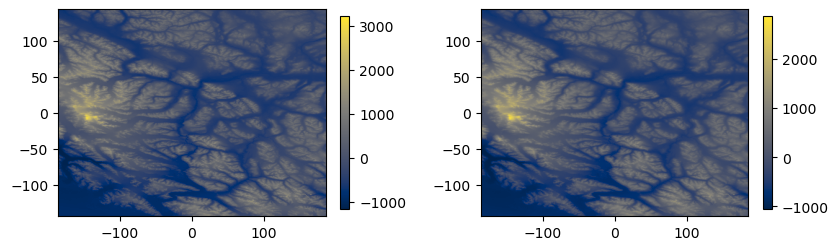

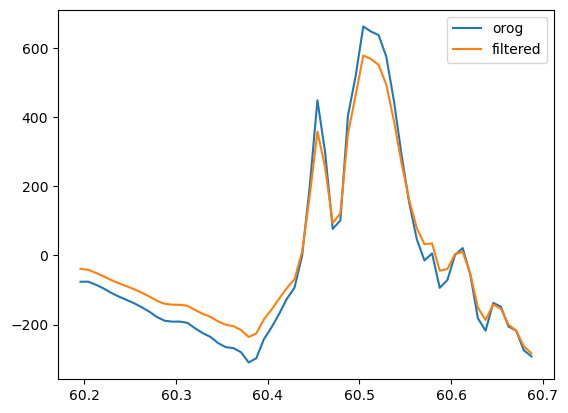

In [830]:
ampls = np.fft.fft2(topo_blur)
# ampls = np.abs(ampls) / cell.topo.size
Ks = np.fft.fftfreq(ampls.shape[1], d=0.08491180322081891).reshape(1,-1)
Ls = np.fft.fftfreq(ampls.shape[0], d=0.08491180322081891).reshape(-1,1)
# print(Ks.shape, Ls.shape)
# print(Ks)

kls = (Ks**2 + Ls**2)**0.5

# print(kls.shape)
ampls *= np.exp(-(kls / (2.0 * np.pi * 5))**0.5)
inverse = np.fft.ifft2(ampls).real

amtrunc = np.copy(ampls)
amtrunc = np.abs(amtrunc)
amtrunc = np.sort(amtrunc.reshape(-1,))[::-1][:10]
print(amtrunc)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], inverse)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()

sidx, eidx = 120, 180
plt.plot(cell.lat[sidx:eidx], topo_blur[int(topo_blur.shape[0]/2)][sidx:eidx], label='orog')
plt.plot(cell.lat[sidx:eidx],inverse[int(topo_blur.shape[0]/2)][sidx:eidx], label='filtered')
plt.legend()
plt.show()

[1.53433146e+07 1.24409457e+07 9.44229946e+06 ... 4.64210991e+01
 4.23663079e+01 1.85536919e-09]
(288, 187)
(1, 187) (288, 1)
10.0 1.0
True
0.04264311285843527


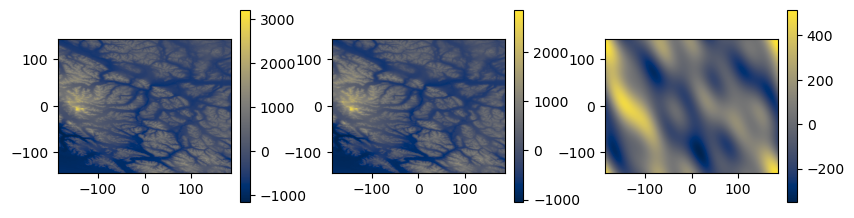

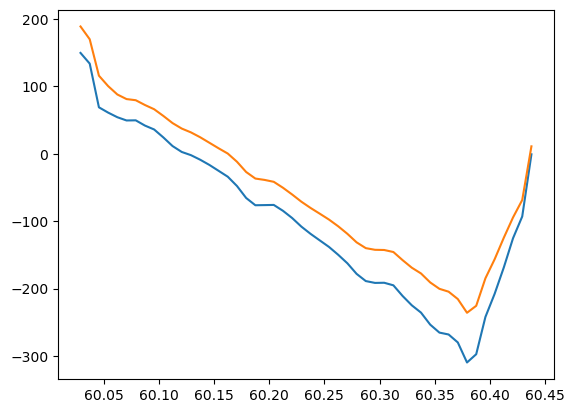

In [824]:
ampls = np.fft.rfft2(topo_blur)
# ampls = np.abs(ampls) / cell.topo.size
Ks = np.fft.rfftfreq((ampls.shape[1] * 2)-1, d=0.08491180322081891).reshape(1,-1)
Ls = np.fft.fftfreq(ampls.shape[0], d=0.08491180322081891).reshape(-1,1)
# print(Ks.shape, Ls.shape)
# print(Ks)

kls = (Ks**2 + Ls**2)**0.5

# print(kls.shape)
ampls *= np.exp(-(kls / (2.0 * np.pi * 5))**0.5)
inverse = np.fft.irfft2(ampls).real

amtrunc = np.copy(ampls)
# amtrunc = np.abs(amtrunc)
amtrunc = np.sort(np.abs(amtrunc).reshape(-1,))[::-1]#[:10]
print(amtrunc)
cutoff = amtrunc[25]

ampls_cpy = np.copy(ampls)
ampls_cpy[np.where(ampls_cpy <= cutoff)] = 0.0

inverse_trunc = np.fft.irfft2(ampls_cpy).real

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

# Ks = np.fft.rfftfreq((ampls.shape[1] * 2)-1,).reshape(1,-1)
# Ls = np.fft.fftfreq(ampls.shape[0],).reshape(-1,1)

sz = cell.topo.size
kks = Ks
lls = Ls

kkg, llg = np.meshgrid(kks, lls)

print(ampls.shape)
print(kks.shape, lls.shape)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = 2.0 * np.abs(ampls_cpy[np.where(ampls > cutoff)]) / sz
analysis.kks = kkg[np.where(ampls > cutoff)]
analysis.lls = llg[np.where(ampls > cutoff)]

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis)

print(uw_ref)

fs = (10,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], inverse)
axs[2] = fig_obj.phys_panel(axs[2], inverse_trunc)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()

sidx, eidx = 100, 150
plt.plot(cell.lat[sidx:eidx], topo_blur[int(topo_blur.shape[0]/2)][sidx:eidx])
plt.plot(cell.lat[sidx:eidx],inverse[int(topo_blur.shape[0]/2)][sidx:eidx])
plt.show()

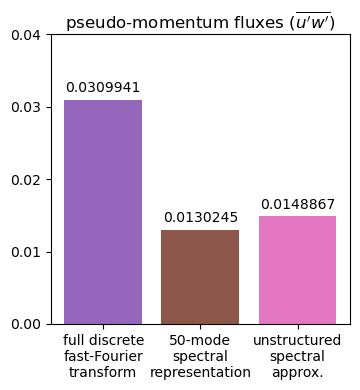

In [834]:
import pandas as pd

XX = pd.Series([uw_ref,uw_50m,uw01],index=['full discrete\nfast-Fourier\ntransform','50-mode\nspectral\nrepresentation','unstructured\nspectral\napprox.'])
fig, (ax1) = plt.subplots(1,1,sharex=True,
                         figsize=(3.7,4.0))
# ax1.spines['bottom'].set_visible(False)
# ax1.tick_params(axis='x',which='both',bottom=False)
# ax2.spines['top'].set_visible(False)

bs = 700
ts = 37500

# ax2.set_ylim(0,bs)
ax1.set_ylim(0,0.04)

bars1 = ax1.bar(XX.index, XX.values, color=('C4', 'C5', 'C6'))
# bars2 = ax2.bar(XX.index, XX.values, color=('C0', 'C1', 'C2', 'r'))
ax1.bar_label(bars1, padding=3)
ax1.set_yticks(np.arange(0.0,0.05,0.01,))
# ax2.bar_label(bars2, padding=3)

# ax2.axhline(np.around(ref_sum, 2), ls='--', c='k')

# for tick in ax2.get_xticklabels():
    # tick.set_rotation(0)
# d = .015  
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)      
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
# kwargs.update(transform=ax2.transAxes)  
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# for b1, b2 in zip(bars1, bars2):
#     posx = b2.get_x() + b2.get_width()/2.
#     if b2.get_height() > bs:
#         ax2.plot((posx-3*d, posx+3*d), (1 - d, 1 + d), color='k', clip_on=False,
#                  transform=ax2.get_xaxis_transform())
#     if b1.get_height() > ts:
#         ax1.plot((posx-3*d, posx+3*d), (- d, + d), color='k', clip_on=False,
#                  transform=ax1.get_xaxis_transform())
        
plt.title("pseudo-momentum fluxes ($\overline{u^\prime w^\prime}$)", fontsize=12, pad=-10)
plt.tight_layout()
plt.savefig('output/pmf_T%i_T%i_large.pdf' %(idx_name[0], idx_name[1]))
plt.show()

In [56]:
print(topo.lat_grid[cell.mask].shape)

(1440, 3720)
(1440, 3720)
(53755,)


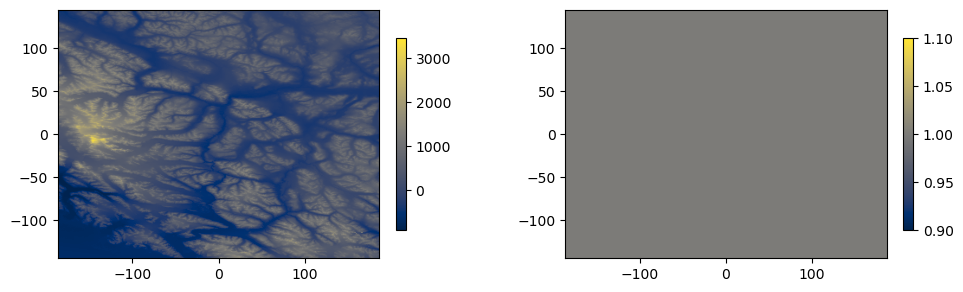

(288, 372)


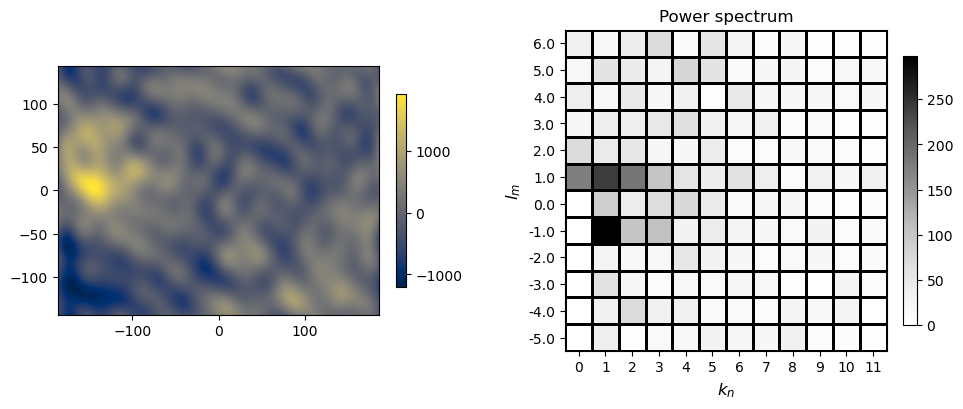

4761.085682507104
30.241285512884666
50
(50,) (50,) (50,)
10.0 1.0
True
uw_50m = 0.013024455249923829


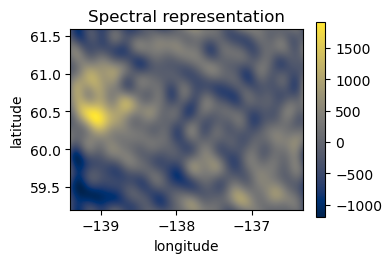

In [817]:
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)

cell0 = all_cells[0]

cell0.mask[...] = 1

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], cell0.topo)
axs[1] = fig_obj.phys_panel(axs[1], cell0.mask)
plt.show()

cell0.topo_m = cell0.topo[cell0.mask]
cell0.topo_m -= cell0.topo_m.mean()
cell0.lat_m = cell0.lat_grid[cell0.mask]
cell0.lon_m = cell0.lon_grid[cell0.mask]

fobj.do_full(cell0)
am, data_recons = lin_reg.do(fobj, cell0, lmbda = 0.0)

print(cell.topo.shape)

dat_2D = reconstruction.recon_2D(data_recons, cell0)

fobj.get_freq_grid(am)
freqs = np.abs(fobj.ampls)

cell0.analysis.get_attrs(fobj, freqs)

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()

print(freqs.sum())

#################################

# ampls = fobj.ampls
amtrunc = np.copy(freqs)
amtrunc = np.sort(amtrunc.reshape(-1,))[::-1]#[:10]
# print(amtrunc)
cutoff = amtrunc[50]

ampls_cpy = np.copy(fobj.ampls)
# ampls_cpy[np.where(ampls_cpy <= cutoff)] = 0.0

print(cutoff)
print(len(freqs[np.where(freqs > cutoff)]))

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = fobj.m_i / (fobj.Ni)
lls = fobj.m_j / (fobj.Nj)

kkg, llg = np.meshgrid(kks, lls)

cell0.analysis.ampls = np.abs(ampls_cpy[np.where(freqs > cutoff)])
cell0.analysis.kks = kkg[np.where(freqs > cutoff)]
cell0.analysis.lls = llg[np.where(freqs > cutoff)]

ddd = cell0.analysis
print(ddd.kks.shape, ddd.lls.shape, ddd.ampls.shape)

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_50m = ideal.compute_uw_pmf(cell0.analysis)

print("uw_50m =", uw_50m)

fs = (4.0,4.2)
fig, axs = plt.subplots(1,1, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs = fig_obj.phys_panel(axs, dat_2D, title='Spectral representation', xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()])
plt.tight_layout()
plt.savefig('output/spec_rep_topo_T%i_T%i.pdf' %(idx_name[0], idx_name[1]))
plt.show()

In [233]:
print(fobj.Nj)
print(fobj.I)

print(fobj.Nj)
print(fobj.J)

288
[  0   1   2 ... 368 369 370]
288
[  0   0   0 ... 287 287 287]


In [805]:
fft_ampls = np.fft.rfft2(cell0.topo - cell0.topo.mean())
# fft_ampls = np.fft.rfft2(topo_blur)
fft_ampls = np.abs(fft_ampls) / cell0.topo.size
fft_freqs = np.copy(fft_ampls)

# sz_fft = fft_ampls.size
# fft_add_ampls = fft_ampls.reshape(-1,)[1:int(sz_fft/2+1)] + fft_ampls.reshape(-1,)[int(sz_fft/2):][::-1]
# fft_add_ampls = np.append(fft_ampls[0], fft_add_ampls)

# print(np.sort(fft_add_ampls)[::-1])

print(fft_ampls.max())
print(freqs.max())

print(fft_ampls.sum())
print(freqs.sum())

ampls_sorted = np.sort(fft_ampls.reshape(-1,))[::-1][:288]
# print(ampls_sorted)
# ampls_summed = ampls_sorted[1::2] + ampls_sorted[:-1:2]

# print(ampls_summed)

print(2.0 * ampls_sorted[:26])

print(np.sort(freqs.reshape(-1,))[::-1][:26])
print(ampls_summed.sum())
print(np.sort(freqs.reshape(-1,))[::-1].sum())


# print(np.sort(fft_ampls.reshape(-1,))[::-1].sum())

# print(np.sort(freqs.reshape(-1,))[::-1].sum())


510.5038612202411
1021.0077224403758
25397.29322584335
6045.860012864768
[1021.00772244 1021.00772244  286.38404505  245.86298792  245.86298792
  228.24929318  206.89808055  189.29340208  189.29340208  159.6843602
  151.06557204  144.16920751  144.16920751   99.96585658   99.96585658
   97.36629597   95.37145175   79.09628415   77.8693294    73.70982352
   72.55429952   70.64068301   69.6399173    69.6399173    65.32718104
   65.22112438]
[1021.00772244  286.38404505  245.86298792  228.24929318  206.89808055
  189.29340208  159.6843602   151.06557204  144.16920751   99.96585658
   97.36629597   95.37145175   79.09628415   73.70982352   72.55429952
   70.64068301   65.32718104   65.22112438   64.81556389   61.86060051
   60.07355647   59.75712096   59.34196732   58.03547321   54.76463552
   53.26179484]
4999.476028516102
6045.860012864768


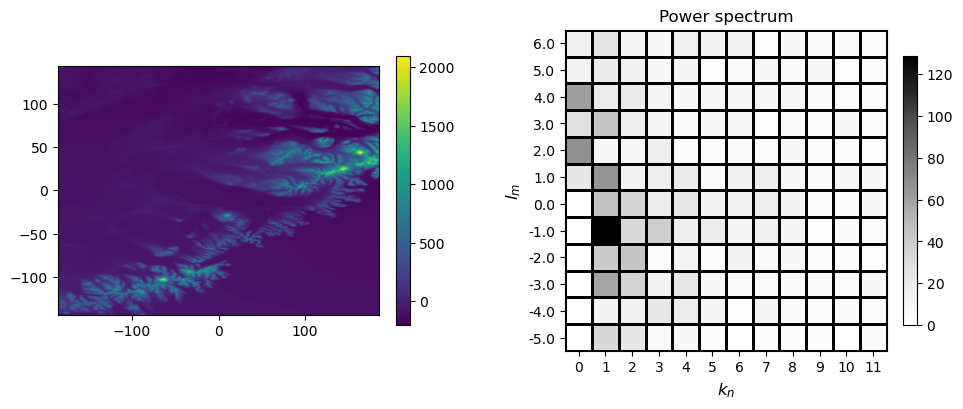

In [409]:
fft_ampls = np.fft.fft2(cell0.topo - cell0.topo.mean())

physical = np.fft.ifft2(fft_ampls).real

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], physical)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()



AttributeError: 'topo_cell' object has no attribute 'I'